In [2]:
# pip install numpy pandas scikit-learn xgboost catboost matplotlib

# !pip install imbalanced-learn


In [3]:
# pip install xgboost
# pip install catboost
#
# pip install imbalanced-learn
# pip install numpy

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import xgboost as xgb

print("All libraries imported successfully!")

All libraries imported successfully!


# Hong Kong Air Quality Health Index Analysis

This notebook loads hourly Air Quality Health Index (AQHI) data from the Hong Kong Environmental Protection Department, cleans and reshapes the data, performs basic exploratory analysis, and builds a simple classification model to predict AQHI risk categories.

The AQHI data files are monthly CSVs (English version). Each file contains notes in the first few lines, then a header row followed by hourly values for each monitoring station.


In [4]:
import pandas as pd
import numpy as np
from io import StringIO
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


## Helper functions

In [5]:
def load_aqhi_csv(path):
    """Load and clean a monthly AQHI CSV file.

        The function skips the notes at the top of the file, fills missing dates and hours,
        removes asterisks from values, converts numeric fields, and returns a cleaned DataFrame.
        功能详解：

            跳过文件顶部的说明文字（直到遇到 "Date" 这一行才开始读取）
            去除值中的 * 字符（这些通常表示“估算值”或“异常值”）
            将数值字段转为数值类型
            填补缺失日期和小时  
            计算出完整的 Datetime 时间戳
    """
    with open(path, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()
    header_idx = next(i for i,line in enumerate(lines) if line.strip().startswith('Date'))
    csv_data = ''.join(lines[header_idx:])
    df = pd.read_csv(StringIO(csv_data))
    for col in df.columns[2:]:
        df[col] = df[col].astype(str).str.replace('*','', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df['Date'] = df['Date'].ffill()
    df['Hour'] = pd.to_numeric(df['Hour'], errors='coerce')
    df['Hour'] = df['Hour'].ffill()
    df = df.dropna(subset=['Hour'])
    df['Hour'] = df['Hour'].astype(int)
    hour_offset = (df['Hour'] - 1) % 24
    df['Datetime'] = pd.to_datetime(df['Date']) + pd.to_timedelta(hour_offset, unit='h')
    return df

## Load and combine monthly data

In [6]:

# Specify the directory containing downloaded CSV files
# By default, data files should be in the same folder as this notebook
# 加载所有文件, 并合并所有文件到一个文件: all_df
data_dir = Path('Datasets')
monthly_files = ['202501_Eng.csv','202502_Eng.csv','202503_Eng.csv','202504_Eng.csv','202505_Eng.csv']

monthly_dfs = []
for fname in monthly_files:
    file_path = data_dir / fname
    if file_path.exists():
        df_month = load_aqhi_csv(file_path)
        monthly_dfs.append(df_month)
    else:
        print(f"Warning: {fname} not found. Skipping.")

all_df = pd.concat(monthly_dfs, ignore_index=True)
print('Combined shape:', all_df.shape)
all_df.head()


Combined shape: (3775, 21)


,Date,Hour,Central/Western,Southern,Eastern,Kwun Tong,Sham Shui Po,Kwai Chung,Tsuen Wan,Tseung Kwan O,...,Tuen Mun,Tung Chung,Tai Po,Sha Tin,North,Tap Mun,Causeway Bay,Central,Mong Kok,Datetime
0,2025-01-01,1,6.0,6,6.0,6.0,5.0,5.0,5,6.0,...,5.0,4.0,5.0,5.0,5.0,5.0,5.0,6.0,5.0,2025-01-01 00:00:00
1,2025-01-01,2,7.0,6,5.0,5.0,5.0,5.0,5,5.0,...,5.0,5.0,5.0,6.0,5.0,5.0,5.0,6.0,5.0,2025-01-01 01:00:00
2,2025-01-01,3,7.0,5,5.0,5.0,5.0,5.0,5,5.0,...,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2025-01-01 02:00:00
3,2025-01-01,4,6.0,5,5.0,5.0,5.0,5.0,5,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2025-01-01 03:00:00
4,2025-01-01,5,5.0,5,5.0,5.0,5.0,5.0,5,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2025-01-01 04:00:00


## Reshape to long format

In [7]:

long_df = all_df.melt(id_vars=['Datetime','Date','Hour'], var_name='Station', value_name='AQHI')
long_df = long_df.dropna(subset=['AQHI'])
print("Long format shape:", long_df.shape)
long_df.head()
# long_df['Station'].unique()


Long format shape: (67837, 5)


,Datetime,Date,Hour,Station,AQHI
0,2025-01-01 00:00:00,2025-01-01,1,Central/Western,6.0
1,2025-01-01 01:00:00,2025-01-01,2,Central/Western,7.0
2,2025-01-01 02:00:00,2025-01-01,3,Central/Western,7.0
3,2025-01-01 03:00:00,2025-01-01,4,Central/Western,6.0
4,2025-01-01 04:00:00,2025-01-01,5,Central/Western,5.0


## Exploratory data analysis

count    67837.000000
mean         3.772528
std          1.351221
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         10.000000
Name: AQHI, dtype: float64


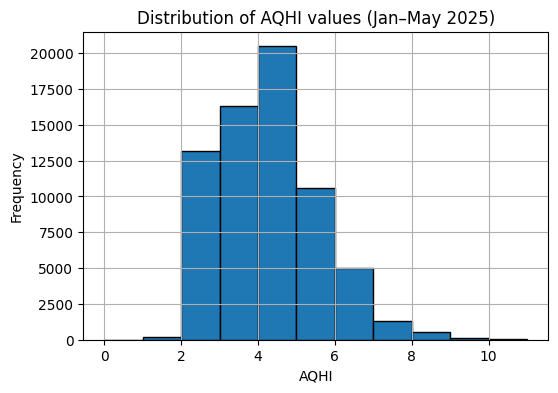

Station
Eastern            3.980382
Tai Po             3.926790
Causeway Bay       3.923607
Tuen Mun           3.905951
Tseung Kwan O      3.866048
Central/Western    3.862636
Mong Kok           3.842259
Central            3.806255
Southern           3.782781
Kwun Tong          3.782286
Sham Shui Po       3.764113
North              3.721485
Kwai Chung         3.719247
Tap Mun            3.696189
Tung Chung         3.668790
Sha Tin            3.668081
Yuen Long          3.541744
Tsuen Wan          3.446623
Name: AQHI, dtype: float64


In [8]:

print(long_df['AQHI'].describe())
plt.figure(figsize=(6,4))
long_df['AQHI'].hist(bins=range(0,12), edgecolor='black')
plt.title('Distribution of AQHI values (Jan–May 2025)')
plt.xlabel('AQHI')
plt.ylabel('Frequency')
plt.show()

station_mean = long_df.groupby('Station')['AQHI'].mean().sort_values(ascending=False)
print(station_mean)


In [9]:
long_df.head()


,Datetime,Date,Hour,Station,AQHI
0,2025-01-01 00:00:00,2025-01-01,1,Central/Western,6.0
1,2025-01-01 01:00:00,2025-01-01,2,Central/Western,7.0
2,2025-01-01 02:00:00,2025-01-01,3,Central/Western,7.0
3,2025-01-01 03:00:00,2025-01-01,4,Central/Western,6.0
4,2025-01-01 04:00:00,2025-01-01,5,Central/Western,5.0


## Feature engineering and classification model

# Random Forest Classifier

In [10]:

def categorize(aqhi):
    if aqhi <= 3:
        return 'Low'
    elif aqhi <= 6:
        return 'Moderate'
    elif aqhi <= 8:
        return 'High'
    elif aqhi <= 10:
        return 'Very High'
    else:
        return 'Serious'

#  增加属性 
long_df['RiskCategory'] = long_df['AQHI'].apply(categorize)

long_df['Hour_of_Day'] = long_df['Datetime'].dt.hour
long_df['Day_of_Week'] = long_df['Datetime'].dt.dayofweek

# 建立模型
X = long_df[['Station','Hour_of_Day','Day_of_Week']]
y = long_df['RiskCategory' ]

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Station'])
], remainder='passthrough')

clf = Pipeline(steps=[('preprocess', preprocess),
                    ('model', RandomForestClassifier(n_estimators=200, random_state=42))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('===========================')
print(classification_report(y_test, y_pred))


Accuracy: 0.5351808176100629
              precision    recall  f1-score   support

        High       0.00      0.00      0.00       553
         Low       0.49      0.39      0.43      8902
    Moderate       0.56      0.69      0.61     10837
   Very High       0.00      0.00      0.00        60

    accuracy                           0.54     20352
   macro avg       0.26      0.27      0.26     20352
weighted avg       0.51      0.54      0.52     20352



/opt/anaconda3/envs/COM6005/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/COM6005/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/COM6005/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

In [11]:
long_df.head()
long_df.to_csv("./Datasets/long_df_cleaned.csv", index=False)

In [12]:
# !pip install seaborn

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv("./Datasets/long_df_cleaned.csv")

# 转换日期时间列
df["Datetime"] = pd.to_datetime(df["Datetime"])
df["Date"] = pd.to_datetime(df["Date"])

# 创建时间特征
df["Month"] = df["Datetime"].dt.month
df["Day"] = df["Datetime"].dt.day
df["Is_weekend"] = (df["Day_of_Week"] >= 5).astype(int)
df["Season"] = df["Month"].apply(lambda x: (x % 12 + 3) // 3)  # 1:春, 2:夏, 3:秋, 4:冬

# 创建滞后特征
df["AQHI_lag1"] = df["AQHI"].shift(1)
df["AQHI_lag24"] = df["AQHI"].shift(24)  # 前一天同一时间

# 创建滚动统计特征
df["AQHI_rolling_mean_3"] = df["AQHI"].rolling(window=3).mean()
df["AQHI_rolling_mean_24"] = df["AQHI"].rolling(window=24).mean()

# 编码分类变量
le_risk = LabelEncoder()
df["RiskCategory_encoded"] = le_risk.fit_transform(df["RiskCategory"])

# 处理缺失值（由于滞后特征产生的）
df = df.dropna()

# 选择特征
features = [
    "Hour_of_Day",
    "Day_of_Week",
    "Month",
    "Day",
    "Is_weekend",
    "Season",
    "AQHI_lag1",
    "AQHI_lag24",
    "AQHI_rolling_mean_3",
    "AQHI_rolling_mean_24",
]

X = df[features]
y = df["AQHI"]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # 时间序列不随机打乱
)

print(f"训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")

训练集大小: (54250, 10)
测试集大小: (13563, 10)


# Use XGBoost predict model

In [14]:
# XGBoost训练（避免参数问题）
xgb_model_simple = xgb.XGBRegressor(
    n_estimators=500,  # 减少树的数量
    # learning_rate=0.1,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
)

# 训练模型
print("开始训练XGBoost模型...")
xgb_model_simple.fit(X_train, y_train)
print("模型训练完成!")

开始训练XGBoost模型...
模型训练完成!


模型评估结果:
均方误差 (MSE): 0.0343
均方根误差 (RMSE): 0.1851
平均绝对误差 (MAE): 0.0824
R² 分数: 0.9815


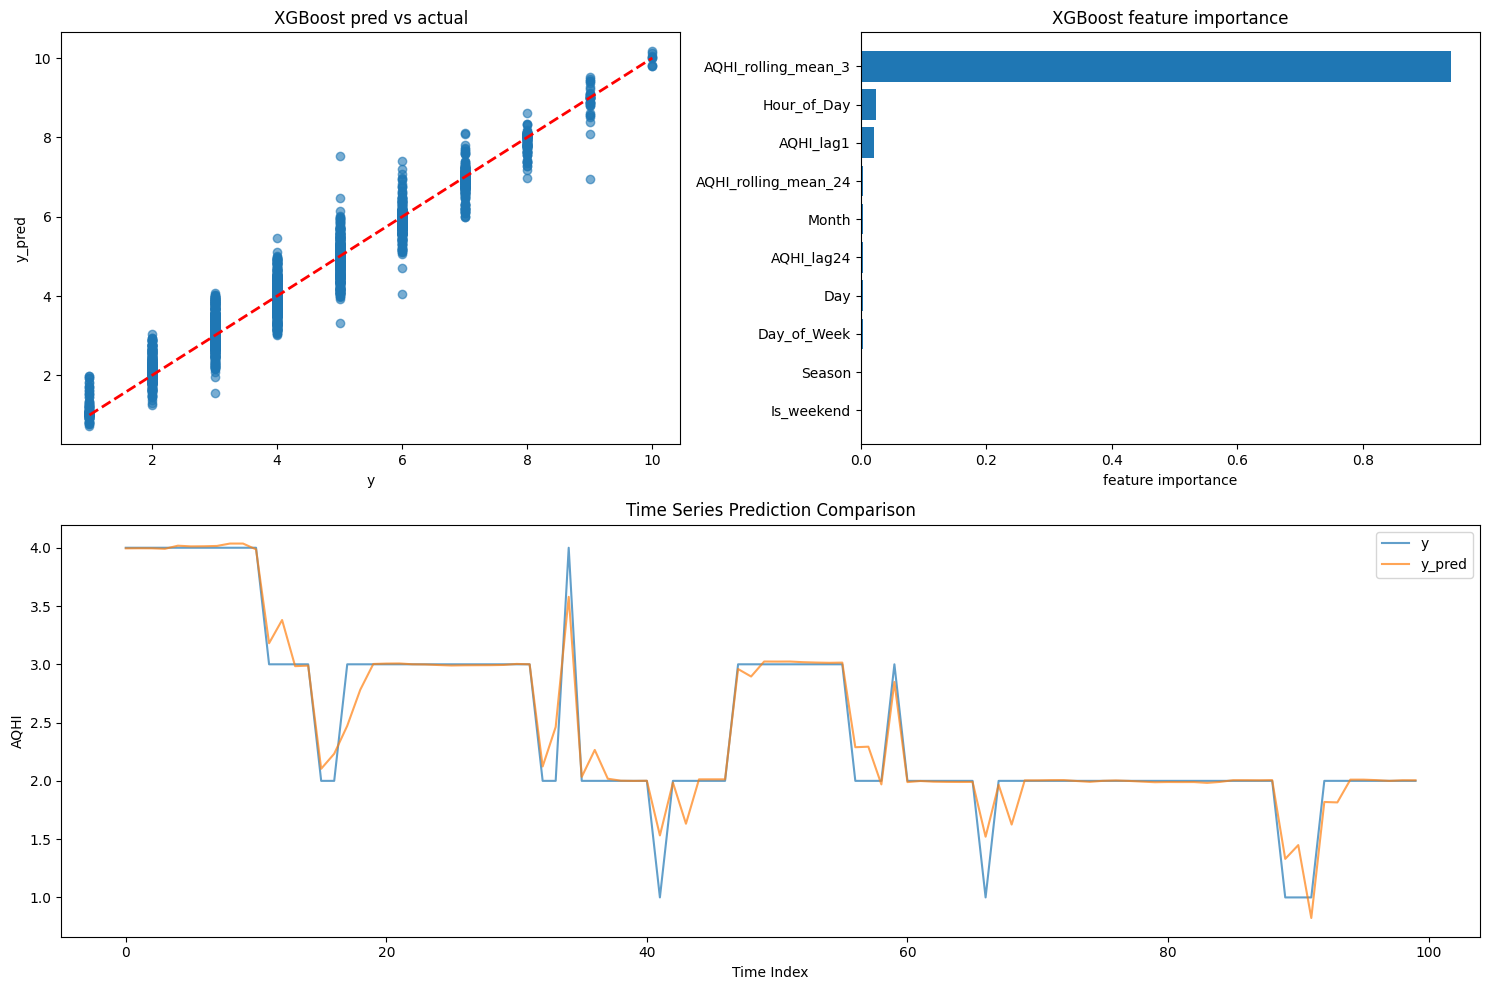

In [15]:
# 预测
y_pred = xgb_model_simple.predict(X_test)

# 评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"模型评估结果:")
print(f"均方误差 (MSE): {mse:.4f}")
print(f"均方根误差 (RMSE): {rmse:.4f}")
print(f"平均绝对误差 (MAE): {mae:.4f}")
print(f"R² 分数: {r2:.4f}")

# 可视化预测结果
plt.figure(figsize=(15, 10))

# 1. 预测vs实际值散点图
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("y")
plt.ylabel("y_pred")
plt.title("XGBoost pred vs actual")

# 2. 特征重要性
plt.subplot(2, 2, 2)
feature_importance = xgb_model_simple.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("feature importance")
plt.title("XGBoost feature importance")

# 3. 时间序列预测对比（前100个样本）
plt.subplot(2, 1, 2)
plt.plot(y_test.values[:100], label="y", alpha=0.7)
plt.plot(y_pred[:100], label="y_pred", alpha=0.7)
plt.xlabel("Time Index")
plt.ylabel("AQHI")
plt.title("Time Series Prediction Comparison")
plt.legend()

plt.tight_layout()
plt.show()